# Super-resolution

This example demonstrates the use of neural operators for
super-resolution.

We will employ the FLAME dataset, a set of flow samples of size 32x32 that
should be up-sampled to 128x128. Download the data set from
[Kaggle](https://www.kaggle.com/competitions/2023-flame-ai-challenge/data)
and put it into the `data/flame` directory.

## Setup

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import torch
import matplotlib.pyplot as plt
from continuity.data import SelfSupervisedOperatorDataset
from continuity.data import Flame, FlameDataLoader
from continuity.operators import DeepONet
from continuity.callbacks import PrintTrainingLoss, LearningCurve

In [8]:
torch.manual_seed(1)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Dataset

We create a `FlameDataSet` that exports batches of samples
from the FLAME data. The data set contains train/val splits
and has four channels `ux`, `uy`, `uz`, and `rho`. In this example,
we only use channel `ux` from the first samples of the train split.

In [9]:
import pathlib

flame_dir = pathlib.Path.cwd().joinpath("..", "data", "flame")
if flame_dir.joinpath("flowfields").is_file():
    N = 4
    loader = FlameDataLoader(path='../data/flame')
    flame = Flame(loader, size=N, split="train", channels=["ux"])
else:
    N = 1
    class DummyFlame:
        x = torch.randn(N, 256, 2)
        u = torch.randn(N, 256, 1)
        y = torch.randn(N, 16384, 2)
        v = torch.randn(N, 16384, 1)

        def __getitem__(self, i):
            return self.x[i], self.u[i], self.y[i], self.v[i]

    flame = DummyFlame()
    

# Print shapes of first sample
x, u, y, v = flame[0]
print(f"Shapes:\n x={x.shape}\n u={u.shape}\n y={y.shape}\n v={v.shape}")

Shapes:
 x=torch.Size([256, 2])
 u=torch.Size([256, 1])
 y=torch.Size([16384, 2])
 v=torch.Size([16384, 1])


# Plotting

We can use matplotlib to visualize the provided data.

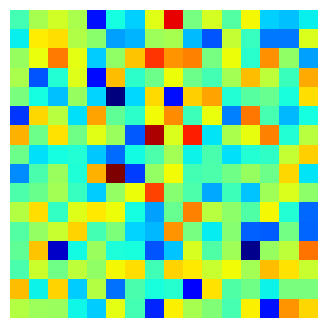

In [10]:
fig, ax = plt.subplots(1, N, figsize=(4 * N, 4))
if N == 1:
    ax = [ax]
for i in range(N):
    u = flame[i][1]
    um = u.reshape((16, 16)).flip(1).T.cpu()
    ms = ax[i].matshow(um, cmap="jet")
    ax[i].axis('off')

# Self-supervised training

In [11]:
dataset = SelfSupervisedOperatorDataset(flame.x, flame.u)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
print(f"DataLoader contains {len(dataloader)} batches with batch size {dataloader.batch_size}.")

DataLoader contains 8 batches with batch size 32.


# Operator

We define a `DeepONet` to map the low-resolution data to a continuous function,
which we can sample afterwards to compare to the high-resolution data.

In [12]:
operator = DeepONet(
    dataset_shape=dataset.shape,
    trunk_depth=64,
)

# Training

With the DataSet at hand, training is straightforward using the `fit` method.

Model parameters: 79600
Epoch 100:  loss/train = 5.4874e-01  (0.09 s/epoch)


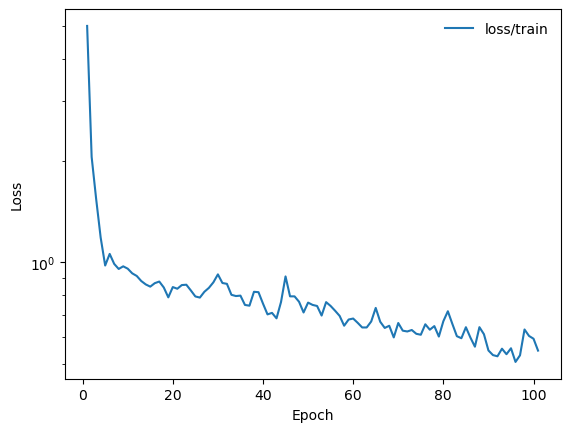

In [13]:
optimizer = torch.optim.Adam(operator.parameters(), lr=1e-3)
operator.compile(optimizer)

callbacks = [PrintTrainingLoss(), LearningCurve()]
operator.fit(dataloader, epochs=100, callbacks=callbacks)

# Evaluating

We can evaluate the trained operator at arbitrary positions,
so let's plot the mapped function with sampled on a finer grid -
with 100 positions instead of 16 we trained on!

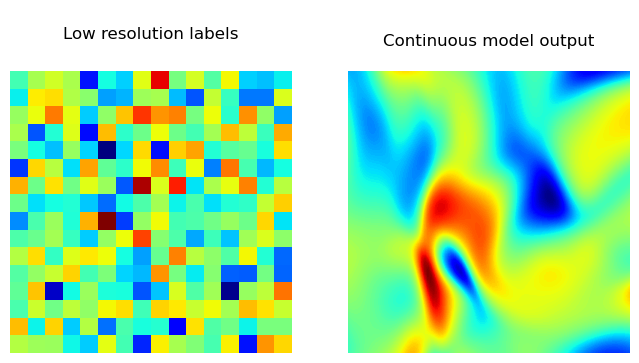

In [14]:
a = torch.linspace(-1, 1, 100) # > 16 (!)
X, Y = torch.meshgrid(a, a, indexing='ij')
yy = torch.stack([X.flatten(), Y.flatten()], dim=1)

for i in range(N):
    x, u, _, _ = flame[i]
    vv = operator(x.unsqueeze(0), u.unsqueeze(0), yy.unsqueeze(0)).squeeze(0)
    vv = vv.detach().cpu().reshape(X.shape)

    _, ax = plt.subplots(1, 2, figsize=(8, 4))
    um = u.reshape((16, 16)).flip(1).T.cpu()
    ax[0].matshow(um, cmap="jet")
    ax[1].contourf(X, Y, vv, levels=200, cmap='jet')
    ax[1].set_aspect('equal')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title("\nLow resolution labels")
    ax[1].set_title("Continuous model output\n")
    plt.show()